<a href="https://colab.research.google.com/github/NBandemer/capstone-mayo/blob/t5/T5_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Necessary libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
import datetime
import os
import warnings
import json

import torch
from torch.optim import AdamW
from transformers import T5ForSequenceClassification, T5Tokenizer, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
from transformers import EarlyStoppingCallback
from transformers import get_linear_schedule_with_warmup
from tensorboard.backend.event_processing import event_accumulator

In [2]:
# data preprocessing and train-test split
# load the preprocessed dataset from a CSV file
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/PREPROCESSED-NOTES.csv")

# extract text data and specific SDoH categories from the dataset
text_data = dataset["text"].to_list()
sdoh_data = {
    "sdoh_community_present": dataset["sdoh_community_present"].to_list(),
    "sdoh_community_absent": dataset["sdoh_community_absent"].to_list(),
    "sdoh_education": dataset["sdoh_education"].to_list(),
    "sdoh_economics": dataset["sdoh_economics"].to_list(),
    "sdoh_environment": dataset["sdoh_environment"].to_list(),
    "behavior_alcohol": dataset["behavior_alcohol"].to_list(),
    "behavior_tobacco": dataset["behavior_tobacco"].to_list(),
    "behavior_drug": dataset["behavior_drug"].to_list()
}

# prepare directories for storing train-test split data for each SDoH category
base_path = 'test_train_split/behavior_drug'
os.makedirs(base_path, exist_ok=True)

# Iterate through each SDOH data category to split and save as separate CSV files
for category, data in sdoh_data.items():
    base_path = f"test_train_split/{category}"
    os.makedirs(base_path, exist_ok=True)

    # Split data for the current category into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        text_data, data, random_state=0, train_size=0.8, stratify=data
    )

    # Save all splits as CSV files
    pd.DataFrame({"text": X_train}).to_csv(f"{base_path}/X_train.csv", index=False)
    pd.DataFrame({"text": X_val}).to_csv(f"{base_path}/X_val.csv", index=False)
    pd.DataFrame({category: y_train}).to_csv(f"{base_path}/y_train.csv", index=False)
    pd.DataFrame({category: y_val}).to_csv(f"{base_path}/y_val.csv", index=False)

In [3]:
# Functions

def save_metrics_to_csv(json_filepath, csv_filename):
    with open(json_filepath) as file:
        data = json.load(file)

        log_history = data['log_history']
        df = pd.DataFrame(log_history)

        df.to_csv(csv_filename, index=False)

def plot_metric_from_tensor(log_dir, output_dir, steps_per_epoch):

    # Calculate steps_per_epoch based on training data and training arguments
    # steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    graph1_data = event_acc.Scalars("eval/loss")
    graph2_data = event_acc.Scalars("train/loss")

    # convert steps to epochs
    epochs1 = [event.step / steps_per_epoch for event in graph1_data]
    values1 = [event.value for event in graph1_data]

    epochs2 = [event.step / steps_per_epoch for event in graph2_data]
    values2 = [event.value for event in graph2_data]

    plt.figure(figsize=(10, 6))

    plt.plot(epochs1, values1, label="Validation Loss")
    plt.plot(epochs2, values2, label="Train Loss")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Overlap")
    # plt.show()

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the graph to the specified folder
    plt.savefig(os.path.join(output_dir, 'metrics_plot.png'))
    plt.show()

# evaluation metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def get_latest_checkpoint(folder_path):
    # Get a list of all files and directories in the specified folder
    files_and_dirs = os.listdir(folder_path)

    # Filter only directories (assumed to be checkpoints)
    checkpoint_dirs = [d for d in files_and_dirs if os.path.isdir(os.path.join(folder_path, d))]

    if not checkpoint_dirs:
        print("No checkpoint directories found.")
        return None

    # Extract the checkpoint numbers from the directory names
    checkpoint_numbers = [int(d.split('-')[1]) for d in checkpoint_dirs]

    # Identify the directory with the highest checkpoint number
    latest_checkpoint = os.path.join(folder_path, f"checkpoint-{max(checkpoint_numbers)}")

    return latest_checkpoint

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Define label_columns here
"""label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]"""
label_columns = ['sdoh_community_present']
num_labels = len(label_columns)

tokenizer = T5Tokenizer.from_pretrained("t5-small")
#tokenizer = T5Tokenizer.from_pretrained("t5-small", num_labels=num_labels)
#tokenizer.pad_token = tokenizer.eos_token

configuration = T5ForSequenceClassification.config_class.from_pretrained("t5-small")
#configuration = T5ForSequenceClassification.config_class.from_pretrained("t5-small", num_labels= num_labels)
configuration.pad_token_id = tokenizer.pad_token_id
model = T5ForSequenceClassification(configuration)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens hav

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_featu

In [6]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

In [7]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/PREPROCESSED-NOTES.csv")
text_data = dataset["text"].to_list()
sdoh_data = dataset["sdoh_community_present"].to_list()

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size=0.8,
                                                  stratify=sdoh_data)
max_seq_length = 100

# Calculate the number of trainable parameters in the model
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_MB = num_trainable_params * 4 / (1024 ** 2)
effective_batch = 8 / (50*4*model_size_MB) #gpu/seqlength * 4 * model size

In [ ]:
# DO NOT RUN
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/PREPROCESSED-NOTES.csv")

text_data = dataset["text"].to_list()
sdoh_data = dataset["behavior_alcohol"].to_list()
"""sdoh_data = {
    "sdoh_community_present": dataset["sdoh_community_present"].to_list(),
    "sdoh_community_absent": dataset["sdoh_community_absent"].to_list(),
    "sdoh_education": dataset["sdoh_education"].to_list(),
    "sdoh_economics": dataset["sdoh_economics"].to_list(),
    "sdoh_environment": dataset["sdoh_environment"].to_list(),
    "behavior_alcohol": dataset["behavior_alcohol"].to_list(),
    "behavior_tobacco": dataset["behavior_tobacco"].to_list(),
    "behavior_drug": dataset["behavior_drug"].to_list()
}
"""
base_path = 'test_train_split/behavior_drug'
os.makedirs(base_path, exist_ok=True)

# X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size = .8, stratify=sdoh_data)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0, test_size = .01)
for category, data in sdoh_data.items():
    base_path = f"test_train_split/{category}"
    os.makedirs(base_path, exist_ok=True)

    # Split data for the current category
    X_train, X_val, y_train, y_val = train_test_split(
        text_data, data, random_state=0, train_size=0.8, stratify=data
    ) #maybe try a different test size (0.7/0.3)

        # Save all splits as CSV files
    pd.DataFrame({"text": X_train}).to_csv(f"{base_path}/X_train.csv", index=False)
    pd.DataFrame({"text": X_val}).to_csv(f"{base_path}/X_val.csv", index=False)
    pd.DataFrame({category: y_train}).to_csv(f"{base_path}/y_train.csv", index=False)
    pd.DataFrame({category: y_val}).to_csv(f"{base_path}/y_val.csv", index=False)

max_seq_length = 100

In [8]:
# define training arguments and start training with the Trainer
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

In [9]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        try:
            # Retrieve tokenized data for the given index
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            # Add the label for the given index to the item dictionary
            item['labels'] = torch.tensor(self.labels[idx])
            return item
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            return None

    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = DataLoader(train_encodings, y_train)
val_dataset = DataLoader(val_encodings,y_val)

In [11]:
timestamp_fortrain = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

tensor_logs = f'/content/drive/MyDrive/Colab Notebooks/Capstone/logs/tensor_logs/{timestamp_fortrain}' # create seperate logs for tensor/epoch
os.makedirs(tensor_logs, exist_ok=True)
epoch_logs = f'/content/drive/MyDrive/Colab Notebooks/Capstone/logs/epoch_logs/{timestamp_fortrain}'
os.makedirs(epoch_logs, exist_ok=True)

<ipython-input-9-bc871785f905>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.596000,0.525194,0.744484,0.698837,0.809569,0.744484
2,0.383100,0.368281,0.852669,0.844059,0.869031,0.852669
3,0.268700,0.240845,0.913879,0.913094,0.913856,0.913879
4,0.223700,0.195518,0.928826,0.928196,0.929061,0.928826
5,0.186600,0.226781,0.921708,0.920544,0.923155,0.921708
6,0.169300,0.199147,0.925979,0.925246,0.926341,0.925979
7,0.096200,0.209787,0.934520,0.933872,0.935072,0.934520


<ipython-input-9-bc871785f905>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-bc871785f905>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-bc871785f905>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-bc871785f905>:9: UserWarning: To copy construct from a tens

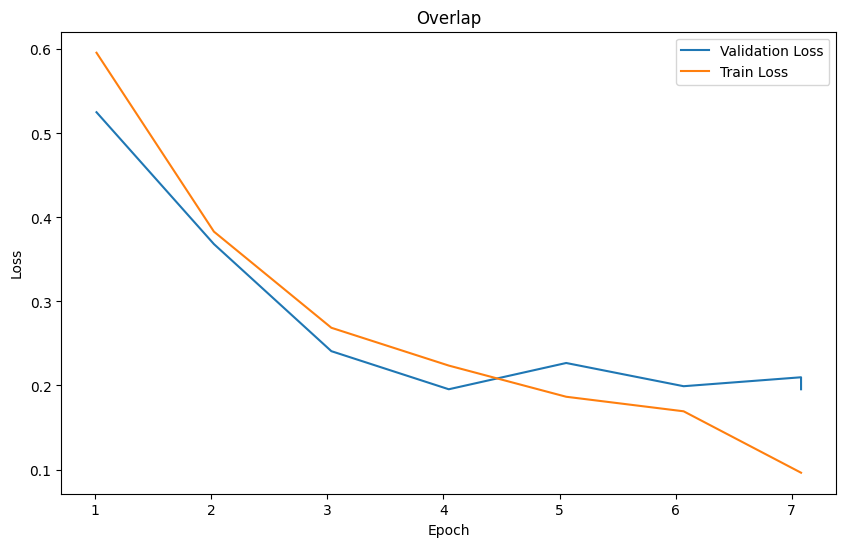

Evaluation Results: {'eval_loss': 0.19551753997802734, 'eval_accuracy': 0.9288256227758007, 'eval_f1': 0.9281955081701352, 'eval_precision': 0.9290612771979371, 'eval_recall': 0.9288256227758007, 'eval_runtime': 4.7566, 'eval_samples_per_second': 295.377, 'eval_steps_per_second': 4.625, 'epoch': 7.0}


In [12]:
"""label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
] # change this
#label_columns = ['sdoh_community_present']
num_labels = len(label_columns)

tokenizer = T5Tokenizer.from_pretrained("t5-small", num_labels=num_labels)
#tokenizer.pad_token = tokenizer.eos_token

configuration = T5ForSequenceClassification.config_class.from_pretrained("t5-small", num_labels= num_labels)
configuration.pad_token_id = tokenizer.pad_token_id
model = T5ForSequenceClassification(configuration)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/PREPROCESSED-NOTES.csv")
text_data = dataset["text"].to_list()
sdoh_data = dataset["behavior_alcohol"].to_list() # change this

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size=0.8,
                                                  stratify=sdoh_data) #make it test = 0.3
max_seq_length = 100  # actually 50 but increase to accomadate outliers

# Calculate the number of trainable parameters in the model
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_MB = num_trainable_params * 4 / (1024 ** 2)
effective_batch = 8 / (50*4*model_size_MB) #gpu/seqlength * 4 * model size

# define training arguments and start training with the Trainer
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

# custom Dataset class for loading training and validation data
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Converting to tensor , maybe use just 'labels'

    def __getitem__(self, idx):
        try:
            item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
            item['labels'] = self.labels[idx].clone().detach()  # Already a tensor, just clone and detach
            return item
        except Exception as e:
            print(f"index error: {idx}: {e}")
            return None

    def __len__(self):
        return len(self.labels) # detach from tensor device

# Initialize the DataLoader for training and validation sets with the tokenized encodings
train_dataset: DataLoader = DataLoader(
    train_encodings,  # These should be the output from the tokenizer
    y_train  # These should be labels, as a list or tensor
)

val_dataset = DataLoader(
    val_encodings,  # These should be the output from the tokenizer
    y_val  # These should be labels, as a list or tensor
)

timestamp_fortrain = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

tensor_logs = f'./logs/tensor_logs/{timestamp_fortrain}' #create seperate logs for tensor/epoch
os.makedirs(tensor_logs, exist_ok=True)
epoch_logs = f'./logs/epoch_logs/{timestamp_fortrain}'
os.makedirs(epoch_logs, exist_ok=True)
"""

# training args - need to adjust
training_args = TrainingArguments(
    output_dir= epoch_logs,  # change to epoch log directory, convert to a text
    logging_strategy='epoch',  # characterize as epoch
    num_train_epochs=7, # have high epoch
    #per_device_train_batch_size=64,  # cpu constraint,  64 approp
    per_device_train_batch_size=64, #reduced batch sie
    per_device_eval_batch_size=64,  # gradient accum if batch size of two, 64 approp
    save_strategy= 'epoch',
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir= tensor_logs,  # change to tensor logs
    #eval_steps=100,
    evaluation_strategy="epoch",
    #accumulate gradients over 4 steps
    #gradient_accumulation_steps = 4
    load_best_model_at_end=True,  # This will load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use eval_loss to determine the best model
    greater_is_better=False,  # Set to False because a lower loss is better

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # 3 is a balance between giving the model enough chance  to improve and stopping early enough to prevent overfitting and unnecessary computation
)

# train the model
trainer.train()

# evaluate the model
evaluation_results = trainer.evaluate()

#readable results
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
latest_checkpoint = get_latest_checkpoint(epoch_logs) # latest checkpoint update to csv
json_path = os.path.join(latest_checkpoint, 'trainer_state.json')
save_metrics_to_csv(json_path, 'eval_metric.csv') #update metrics
plot_metric_from_tensor(tensor_logs, 'graphs', steps_per_epoch)

save_directory = "/content/drive/MyDrive/Colab Notebooks/Capstone/t5"

os.makedirs(save_directory, exist_ok=True)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Evaluation Results:", evaluation_results)

In [ ]:
pip install transformers[torch]

In [ ]:
pip install accelerate -U

In [ ]:
# DO NOT RUN
trainer.train()

# Extract loss values
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
val_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plot the training and validation loss
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract evaluation loss values from the log history
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# evaluation loss for all epochs
for epoch, loss in enumerate(eval_losses):
    print(f"Epoch {epoch + 1}: Evaluation Loss = {loss}")

# epoch with the minimum evaluation loss
best_epoch = eval_losses.index(min(eval_losses)) + 1
print(f'Best epoch: {best_epoch}')

"""test_result = trainer.evaluate(val_dataset)
# Report precision, recall, and F1 score
y_true = val_dataset['labels']
y_pred = trainer.predict(val_dataset).label_ids
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}')"""

In [ ]:
# DO NOT RUN
for epoch, loss in enumerate(train_loss):
    print(f"Epoch {epoch + 1}: Train Loss = {loss}")

In [ ]:
# DO NOT RUN
# Saving & Loading the model<br>
save_directory = "/content/drive/MyDrive/Colab Notebooks/Capstone/t5"
os.makedirs(save_directory, exist_ok=True)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)

In [ ]:
# Evaluation on Test Data

# function to evaluate the trained model on test data
def evaluate_on_test_data(model_path, test_data_path, tokenizer_path, label_columns, max_seq_length=512):
    # Load the tokenizer and model
    tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
    model = T5ForSequenceClassification.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load the test data
    test_dataset = pd.read_csv(test_data_path)
    texts = test_dataset["text"].tolist()

    # collect true labels and predictions for each label
    true_labels = {label: test_dataset[label].tolist() for label in label_columns}

    # Tokenize the test data
    test_encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

    # Custom Dataset for test data
    class TestDataset(Dataset):
        def __init__(self, encodings):
            self.encodings = encodings

        def __getitem__(self, idx):
            #return {key: val[idx] for key, val in self.encodings.items()}
              return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        def __len__(self):
            return len(self.encodings.input_ids)

    # prepare DataLoader for test data
    test_dataset = TestDataset(test_encodings)
    test_loader = DataLoader(test_dataset, val_dataset)

    # Prepare to collect predictions
    predictions = {label: [] for label in label_columns}
    results = []

    model.eval()
    with torch.no_grad():
      for batch in test_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        sigmoid_logits = torch.sigmoid(logits).cpu().numpy()  # Apply sigmoid function for binary classification on logits
        threshold = 0.5
        binary_predictions = (sigmoid_logits > threshold).astype(int)  # Apply threshold to get binary predictions
        # Collect binary_predictions for the labels
        for i, label in enumerate(label_columns):
            predictions[label].extend(binary_predictions[:, i])

    # calculate and print the metrics for each label
    for label in label_columns:
        accuracy = accuracy_score(true_labels[label], predictions[label])
        precision = precision_score(true_labels[label], predictions[label], average='weighted')
        recall = recall_score(true_labels[label], predictions[label], average='weighted')
        f1 = f1_score(true_labels[label], predictions[label], average='weighted')
        report = classification_report(true_labels[label], predictions[label], zero_division=0)

          # Append the results for the current label to the list
        results.append({
          'Label': label,
          'Accuracy': accuracy,
          'Precision': precision,
          'Recall': recall,
          'F1 Score': f1
        })

        # Print the results for the current label
        print("Evaluation results saved to /content/model_evaluation_results.csv")
        print(f"Metrics for {label}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Classification Report:")
        print(report)
        print("\n")

        # Convert the list of results to a DataFrame
        results_df = pd.DataFrame(results)

        # Save the DataFrame to a CSV file
        results_df.to_csv('/content/model_evaluation_results.csv', index=False)
        print("Evaluation results saved to /content/model_evaluation_results.csv")
        print("Test evaluation completed for all labels.")

# Paths to the model, tokenizer, and test data
model_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/t5"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/t5"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/PREPROCESSED-NOTES.csv"

# List of label columns in your test data for evaluation
"""label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]"""
label_columns = ['sdoh_community_present']

# Call the function to evaluate on test data
evaluate_on_test_data(model_path, test_data_path, tokenizer_path, label_columns, max_seq_length=512)

In [19]:
from sklearn.metrics import classification_report

test_encodings = tokenizer(text_data, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
test_dataset = DataLoader(test_encodings, sdoh_data)

"""tokenizer = T5Tokenizer.from_pretrained(/content/logs/epoch_logs)
model = T5ForSequenceClassification.from_pretrained(tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)"""

best_checkpoint_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/Capstone/t5")

model = T5ForSequenceClassification.from_pretrained(best_checkpoint_path)
model.to(device)

test_results = trainer.evaluate(test_dataset)

#test_metrics = compute_metrics(test_results)

results = trainer.predict(test_dataset)
print("Prediction:", results)

predicted_labels = results.predictions[0].argmax(-1)
true_labels = test_dataset.labels
# true_labels = test_dataset[label_columns].tolist() #  labels from the DataLoader
target_names_binary = ['sdoh_community_absent', 'sdoh_community_present']

print("Test Results:", test_results)
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=target_names_binary))

<ipython-input-9-bc871785f905>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-9-bc871785f905>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Prediction: PredictionOutput(predictions=(array([[ 4.1010003, -4.674293 ],
       [ 0.6659358, -2.6060843],
       [-3.53474  ,  1.4819527],
       ...,
       [-2.436789 ,  1.3270983],
       [-2.1720557,  1.153169 ],
       [ 0.7330762, -2.8865876]], dtype=float32), array([[[ 0.42700708, -0.18862489, -0.48639557, ...,  0.01541823,
         -0.538374  , -0.3061447 ],
        [-0.5477326 ,  0.08688699,  0.44624352, ...,  0.056337  ,
          0.79815537, -0.12809859],
        [ 0.39677367,  1.2513163 , -1.1322625 , ...,  1.1529073 ,
          0.36044106, -0.7884846 ],
        ...,
        [ 0.7938337 ,  1.0020214 , -0.00569954, ...,  0.17524213,
          0.613088  , -0.3931444 ],
        [ 0.7902924 ,  1.0052366 , -0.01652941, ...,  0.19044717,
          0.6297312 , -0.3970333 ],
        [ 0.7872011 ,  0.998283  , -0.00939967, ...,  0.17383085,
          0.61733955, -0.3937556 ]],

       [[-0.73340195,  0.7174273 ,  0.89764297, ...,  0.90720713,
          0.21869722, -1.74529   ],
  

In [24]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
})
print("Metrics Table:\n", metrics_df)

Metrics Table:
    Accuracy  Precision    Recall  F1 Score
0  0.942349   0.938418  0.973112   0.95545
